In [2]:
# import libraries
import datetime
import dill
import geopandas as gpd
import glob
import matplotlib
import matplotlib.cm as cm
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import numpy as np
import pandas as pd
import os
import rasterio
import rasterstats as rs
import seaborn as sns
from osgeo import gdal

# change some notebook settings
pd.options.display.max_colwidth = 80
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# define paths
workdir = "C://Users/felix/github/sar_parcel_analyses"
fig_path = os.path.join(workdir, "03_figures")

# define plotting settings
sns.set_context("notebook"); # "talk" for larger labels

In [6]:
# # load worksapce image
# dill.load_session(os.path.join(workdir, "scripts", "workspace_save.pkl"))
# # save workspace image
# dill.dump_session(os.path.join(workdir, "scripts", "workspace_save.pkl"))

## 01 Radar preprocessing: creation of stacks

In [3]:
# functions for reading, resampling & stacking images
def reproj_resample_to_ref(reference, secondary):
    # get data for reference (master)
    reference_ds = gdal.Open(reference)
    reference_proj = reference_ds.GetProjection()
    reference_geotrans = reference_ds.GetGeoTransform()
    w = reference_ds.RasterXSize
    h = reference_ds.RasterYSize
    # get data for secondary (slave)
    secondary_ds = gdal.Open(secondary)
    secondary_proj = secondary_ds.GetProjection()
    secondary_geotrans = secondary_ds.GetGeoTransform()
    data_type = secondary_ds.GetRasterBand(1).DataType
    n_bands = secondary_ds.RasterCount
    # perform reprojection & resampling
    filepath = os.path.split(secondary)[0]
    dst_filename = os.path.split(secondary)[-1].replace(".tif", "_resampled.tif")
    dst_raster = os.path.join(filepath, dst_filename)
    dst = gdal.GetDriverByName('GTiff').Create(dst_raster, w, h, n_bands, data_type)
    dst.SetGeoTransform(reference_geotrans)
    dst.SetProjection(reference_proj)
    gdal.ReprojectImage(secondary_ds, dst, secondary_proj, reference_proj, gdal.GRA_NearestNeighbour)
    return dst_raster

def select_bands(raster, band_indices):
    filepath = os.path.split(raster)[0]
    dst_filename = os.path.split(raster)[-1].replace(".tif", "_band.tif")
    dst_raster = os.path.join(filepath, dst_filename)
    dst_ds = gdal.Translate(dst_raster, raster, bandList=band_indices)
    dst_ds.FlushCache()
    return dst_raster

# create stack and save it to disk (manually instead of using es.stack in order to maintain metadata)
# array, raster_prof = es.stack(bands, out_path = os.path.join(stacked_img_path, f"{outname}.tif"))
def create_stack(file_dir, band_index, stacked_img_path, outname):
    # get all multi-band rasters in dir
    dir = file_dir
    files = glob.glob(os.path.join(dir, '*.tif'))
    # resample all rasters to first one to enable stacking
    ref_raster = files[0]
    resampled_rasters = list(map(lambda sec: reproj_resample_to_ref(ref_raster, sec), files))
    # select specific band for each raster
    bands = list(map(lambda rast: select_bands(rast, [band_index]), resampled_rasters))
    # read metadata of band
    with rasterio.open(bands[0]) as src0:
        meta = src0.meta
    # update meta to reflect the number of layers
    meta.update(count = len(bands))
    # write multi-band raster with corresponding band description
    with rasterio.open(os.path.join(stacked_img_path, f"{outname}.tif"), 'w', **meta) as dst:
        for idx, layer in enumerate(bands, start=1):
            with rasterio.open(layer) as src1:
                # write band
                dst.write_band(idx, src1.read(1))
                # write metadata
                meta_pol_time = "_".join(
                    os.path.split(files[idx-1])[-1].split("_", 3)[-1].split(".tif")[0].split("_")[:2]
                    )
                dst.update_tags(idx, NAME=f'{outname}_{meta_pol_time}')
                dst.set_band_description(idx, f'{outname}_{meta_pol_time}')
    # cleanup, print info & return object
    list(map(lambda file: os.remove(file), resampled_rasters))
    list(map(lambda file: os.remove(file), bands))
    n_bands = rasterio.open(os.path.join(stacked_img_path, f"{outname}.tif")).meta["count"]
    print(f"stacked imagery {outname} created, number bands: {n_bands}")

In [3]:
# create stacks of bands for each group of S1 features
intensity_dir = os.path.join(workdir, "02_data_processed", "intensity")
coherence_dir = os.path.join(workdir, "02_data_processed", "coherence")
polarimetry_dir = os.path.join(workdir, "02_data_processed", "polarimetry")
stacked_img_path = os.path.join(workdir, "02_data_processed", "stacked_imagery")

create_stack(intensity_dir, 1, stacked_img_path, "gamma0_VV")
create_stack(intensity_dir, 2, stacked_img_path, "gamma0_VH")
create_stack(coherence_dir, 1, stacked_img_path, "coh_VV")
create_stack(coherence_dir, 2, stacked_img_path, "coh_VH")
create_stack(polarimetry_dir, 1, stacked_img_path, "entropy")
create_stack(polarimetry_dir, 2, stacked_img_path, "anisotropy")
create_stack(polarimetry_dir, 3, stacked_img_path, "alpha")

stacked imagery gamma0_VV created, number bands: 210
stacked imagery gamma0_VH created, number bands: 70
stacked imagery coh_VV created, number bands: 68
stacked imagery coh_VH created, number bands: 68
stacked imagery entropy created, number bands: 70
stacked imagery anisotropy created, number bands: 70
stacked imagery alpha created, number bands: 70


In [5]:
# sanity check: quality control on resampled rasters
print("Mean VV backscattering coefficient for whole scene extent (original vs. resampled)")
# original data
files = glob.glob(os.path.join(intensity_dir, '*.tif'))
# resampled & stacked data
stack = os.path.join(stacked_img_path, "gamma0_VV.tif")
# comparison
for idx in range(0,5):
    name = os.path.split(files[idx])[-1]
    # original file
    a = rasterio.open(files[idx]).read(1)
    a[a == 0] = 'nan'
    a = np.nanmean(a)
    # band in resampled array
    b = rasterio.open(stack).read(idx+1)
    b[b == 0] = 'nan'
    b = np.nanmean(b)
    # print results
    print(f"{name} (band {idx+1}): {a:.3f}, {b:.3f}")

Mean VV backscattering coefficient for whole scene extent (original vs. resampled)
gamma_VV_VH_44_20210404T165829.tif (band 1): 0.152, 0.152
gamma_VV_VH_44_20210410T165913.tif (band 2): 0.165, 0.165
gamma_VV_VH_44_20210416T165829.tif (band 3): 0.178, 0.178
gamma_VV_VH_44_20210422T165913.tif (band 4): 0.168, 0.168
gamma_VV_VH_44_20210428T165830.tif (band 5): 0.142, 0.142


## 02 Field preprocessing

In [4]:
# analyse pre-processing influences
preprocess_stats = {}

# reading fields file
fields = gpd.read_file(os.path.join(workdir, "01_data_raw", "test_area_fields.geojson"))
fields = fields[["fid", "FS_KENNUNG", "SNAR_BEZEICHNUNG", "SNAR_CODE", "SL_FLAECHE_BRUTTO_HA", "geometry"]]
fields = fields.rename(columns={
    "FS_KENNUNG" : "fid_2", 
    "SNAR_BEZEICHNUNG": "field_use", 
    "SNAR_CODE": "usage_code", 
    "SL_FLAECHE_BRUTTO_HA":"size_ha"
    })

# define crs & manually recalculate size
fields = fields.to_crs(32633)
fields["size_ha"] = fields["geometry"].map(lambda p: p.area / 10**4)

# add stats
preprocess_stats["n_pre"] = len(fields)
preprocess_stats["size_pre"] = fields["size_ha"].sum()/100

# translate field usages
translated_field_usage = {
    "KÖRNERMAIS": "maize", 
    "WINTERGERSTE": "winter barley", 
    "WINTERWEICHWEIZEN": "winter wheat", 
    "GRÜNBRACHE": "green fallow", 
    "SOMMERHAFER": "oat", 
    "SOJABOHNEN": "soy", 
}
fields.replace({'field_use': translated_field_usage}, inplace=True)

# exclude small fields & rare crops
fields = fields[fields["size_ha"] > 0.5]
freq_usages = fields.value_counts("field_use")[fields.value_counts("field_use") > 30]
fields = fields[fields["field_use"].isin(freq_usages.index)]

# buffering fields to avoid border effects
# choosing a buffer of 20m 
fields["geometry_buffer"] = fields.buffer(-20)
fields.insert(5, "size_buffer_ha", fields["geometry_buffer"].map(lambda p: p.area / 10**4))

# exclude all fields covered by less than 5 pixels (i.e. 500m2)
excl_fields = fields[fields["size_buffer_ha"] < 0.05]
fields = fields[~fields["fid"].isin(excl_fields["fid"])]

# add stats
preprocess_stats["n_post"] = len(fields)
preprocess_stats["size_post"] = fields["size_ha"].sum()/100
usages = fields.value_counts("field_use")

# print
print(f"{preprocess_stats['n_post']/preprocess_stats['n_pre']:.0%} of all fields in AoI considered for further analyses.")
print(f"In terms of areal coverage this subset represents {preprocess_stats['size_post']/preprocess_stats['size_pre']:.0%}.\n")
print(f"The following usages show the highest abundances:\n{usages}")
fields.head(5)


38% of all fields in AoI considered for further analyses.
In terms of areal coverage this subset represents 73%.

The following usages show the highest abundances:
field_use
maize            269
winter barley    216
winter wheat     140
soy               40
oat               38
green fallow      31
dtype: int64


,fid,fid_2,field_use,usage_code,size_ha,size_buffer_ha,geometry,geometry_buffer
1,87354,92180098,winter wheat,138,2.180543,0.998995,"POLYGON ((420468.027 5326118.412, 420472.208 5326114.942, 420500.117 5326091...","POLYGON ((420503.050 5326115.334, 420503.992 5326115.835, 420514.528 5326122..."
9,87851,92180088,winter barley,110,1.805346,0.192104,"POLYGON ((423686.092 5326903.174, 423709.792 5326907.201, 423776.678 5326920...","POLYGON ((423849.287 5326954.209, 423849.210 5326955.951, 423909.235 5326968..."
10,87852,92180090,winter wheat,138,1.705784,0.791518,"POLYGON ((423521.433 5326668.614, 423500.001 5326677.136, 423487.359 5326682...","POLYGON ((423396.638 5326619.248, 423441.338 5326678.761, 423441.427 5326678..."
13,87923,92180101,winter barley,110,1.324868,0.139216,"POLYGON ((423623.638 5326887.883, 423637.898 5326844.626, 423706.241 5326855...","POLYGON ((423650.340 5326870.765, 423666.659 5326873.352, 423698.230 5326877..."
19,88142,92180091,winter wheat,138,1.951351,0.986836,"POLYGON ((424103.974 5326594.770, 424152.121 5326459.765, 424197.026 5326478...","POLYGON ((424129.885 5326581.655, 424184.615 5326598.054, 424185.178 5326598..."


In [7]:
# define color palette for fields use / crop type
col_field_use = {}
norm = matplotlib.colors.Normalize(vmin=0, vmax=6, clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.Spectral)
col_lst = [mapper.to_rgba(x) for x in range(0,6)]
for use, col in zip(fields["field_use"].unique(), col_lst):
    col_field_use.update({use: col})

<Figure size 432x288 with 0 Axes>

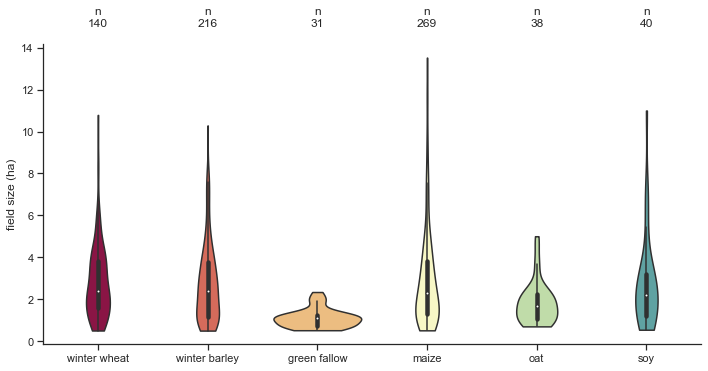

In [7]:
# visualising field characteristics
# distribution of field sizes & number of fields
sns.set_context("notebook")
sns.set_style("ticks")
sns.despine()

ffig = sns.catplot(
    x = "field_use", 
    y = "size_ha", 
    kind = "violin",
    palette = col_field_use,
    cut = 0,
    aspect = 2,
    data = fields)

for xtick, xlab in zip(ffig.axes[0,0].get_xticks(), ffig.axes[0,0].get_xticklabels()):
    ffig.axes[0,0].text(xtick,
                        15, 
                        f"n\n{fields.value_counts('field_use')[xlab.get_text()]}", 
                        horizontalalignment='center',
                        size='medium')

ffig.axes[0,0].set_xlabel('')
ffig.axes[0,0].set_ylabel('field size (ha)')
ffig.savefig(os.path.join(fig_path, f"fields_aoi.png"), dpi=300);

## 03 Field-wise aggregation of SAR data

In [ ]:
# notes
# aggregation of data via lists to derive at tabular format (pd dfs)
# alternative xarray organisation of information may lead to increased flexibility

In [5]:
# calculate temporal statistics for fields & parameters (zonal stats)
buff_fields = fields.drop(columns="geometry")
buff_fields = buff_fields.rename(columns = {"geometry_buffer" : "geometry"})

# function to perform zonal stats given imagery stack
def field_stats(stack_path, fields=buff_fields):
    stack = rasterio.open(stack_path)
    multitemp_stats = []
    for lyr in range(0, stack.meta["count"]):
        lyr_name = stack.tags(lyr+1)["NAME"]
        single_stats = rs.zonal_stats(
            buff_fields, 
            stack.read(lyr+1), 
            nodata=0, 
            affine=stack.profile["transform"],
            stats="count",
            add_stats={f"mean_{lyr_name}": lambda x: np.mean(x)})
        multitemp_stats.append(single_stats)
    return multitemp_stats

# perform calculations for all features
field_agg_stats = [*field_stats(os.path.join(stacked_img_path, "gamma0_VV.tif")),
                   *field_stats(os.path.join(stacked_img_path, "gamma0_VH.tif")),
                   *field_stats(os.path.join(stacked_img_path, "coh_VV.tif")),
                   *field_stats(os.path.join(stacked_img_path, "coh_VH.tif")),
                   *field_stats(os.path.join(stacked_img_path, "entropy.tif")),
                   *field_stats(os.path.join(stacked_img_path, "anisotropy.tif")),
                   *field_stats(os.path.join(stacked_img_path, "alpha.tif"))]

# notes
# zonal stats written to list due to performance reasons instead of created gdf which would also be feasible
# parameters geojson_out=True -> gpd.GeoDataFrame.from_features(stats)
# use xy.iloc[1,:]["mini_raster_array"] (raster_out=True) to get single values
# alternative rs.gen_zonal_stats

In [6]:
# reformat stats result to concatenate them to original fields df
all_stats = pd.DataFrame(field_agg_stats).transpose()

all_fields = []
for idx, field_stat in all_stats.iterrows():
    single_field = {}
    for feature in field_stat.to_list():
        single_field.update(feature)
    del single_field["count"]
    all_fields.append(single_field)

field_agg_stats = pd.DataFrame(all_fields)
field_agg_stats.insert(0, "field_fid", fields["fid"].to_list())
field_agg_stats

,field_fid,mean_gamma0_VV_44_20210404T165829,mean_gamma0_VV_44_20210410T165913,mean_gamma0_VV_44_20210416T165829,mean_gamma0_VV_44_20210422T165913,mean_gamma0_VV_44_20210428T165830,mean_gamma0_VV_44_20210504T165914,mean_gamma0_VV_44_20210510T165830,mean_gamma0_VV_44_20210516T165914,mean_gamma0_VV_44_20210522T165831,...,mean_alpha_95_20210905T051824,mean_alpha_95_20210911T051742,mean_alpha_95_20210917T051824,mean_alpha_95_20210923T051743,mean_alpha_95_20210929T051825,mean_alpha_95_20211005T051743,mean_alpha_95_20211011T051825,mean_alpha_95_20211017T051743,mean_alpha_95_20211023T051825,mean_alpha_95_20211029T051743
0,87354,0.082276,0.132607,0.129458,0.091051,0.031467,0.041003,0.028248,0.049950,0.035961,...,21.674394,23.197966,12.558150,11.806916,15.287312,16.178317,15.932313,17.644585,15.435148,15.081067
1,87851,0.099761,0.145116,0.129308,0.081457,0.068400,0.029576,0.027048,0.041386,0.039461,...,18.653250,23.007068,13.773273,13.831955,16.796588,17.204984,14.632300,17.289413,15.434850,15.161438
2,87852,0.076731,0.138086,0.218903,0.110591,0.039351,0.054955,0.027363,0.039942,0.029313,...,20.032349,19.468474,15.333416,10.889289,11.794978,16.528113,14.311472,12.015952,11.483810,16.799471
3,87923,0.112643,0.106127,0.094472,0.096900,0.065676,0.065251,0.030504,0.064639,0.041893,...,17.338202,17.194499,16.833761,15.144845,19.831860,18.994299,17.225956,19.864154,19.615021,22.701186
4,88142,0.102154,0.153754,0.182121,0.113292,0.034316,0.041245,0.031499,0.034145,0.033056,...,18.290363,18.556683,11.373011,10.897938,11.147692,11.577687,13.790895,13.635364,15.311670,12.407070
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
729,2568748,0.072848,0.108404,0.156009,0.133365,0.036053,0.032826,0.037247,0.148011,0.065383,...,19.225812,20.058320,21.876826,18.934730,19.861456,19.352303,21.952177,18.168129,17.046685,18.637659
730,2568778,0.060469,0.067003,0.151683,0.134168,0.050417,0.055842,0.048130,0.144390,0.079476,...,17.353251,16.053309,18.375856,14.796877,18.581393,15.071450,14.297963,15.560596,14.491982,15.660496
731,2568780,0.062408,0.124705,0.107887,0.065384,0.041530,0.042055,0.021624,0.025410,0.029468,...,11.270875,12.682545,11.586158,14.904684,13.225539,16.089632,17.103439,16.479772,13.768866,13.993504
732,2595302,0.092371,0.101723,0.155205,0.112884,0.101950,0.049242,0.038197,0.174146,0.130699,...,17.509428,19.067154,22.480760,27.667807,31.257609,15.618603,11.503883,11.710042,8.470493,10.714777


In [7]:
# reformat stats into tidy form
field_agg_stats = pd.melt(field_agg_stats, id_vars=["field_fid"], value_vars=field_agg_stats.columns[1:].to_list())
field_agg_stats.insert(1, "feature", [x.split("_")[1] for x in field_agg_stats["variable"]])
field_agg_stats.insert(2, "polarisation", [x.split("_")[2] for x in field_agg_stats["variable"]])
field_agg_stats.loc[~field_agg_stats["polarisation"].isin(["VV", "VH"]), "polarisation"] = np.NaN
field_agg_stats.insert(3, "orbit", [x.rsplit("_",2)[1] for x in field_agg_stats["variable"]])
field_agg_stats['orbit'] = field_agg_stats['orbit'].astype('object')
field_agg_stats.insert(4, "time", [x.rsplit("_",1)[1] for x in field_agg_stats["variable"]])
field_agg_stats["time"] = pd.to_datetime(field_agg_stats["time"], format='%Y-%m-%dT%H:%M:%S')
field_agg_stats.drop(columns=["variable"], inplace=True)

# merge with fields df
merged_df = field_agg_stats.merge(fields, left_on="field_fid", right_on="fid", how='left')
field_agg_stats.insert(1, "size_buffer_ha", merged_df["size_buffer_ha"])
field_agg_stats.insert(1, "size_ha", merged_df["size_ha"])
field_agg_stats.insert(1, "field_use", merged_df["field_use"])

field_agg_stats

,field_fid,field_use,size_ha,size_buffer_ha,feature,polarisation,orbit,time,value
0,87354,winter wheat,2.180543,0.998995,gamma0,VV,44,2021-04-04 16:58:29,0.082276
1,87851,winter barley,1.805346,0.192104,gamma0,VV,44,2021-04-04 16:58:29,0.099761
2,87852,winter wheat,1.705784,0.791518,gamma0,VV,44,2021-04-04 16:58:29,0.076731
3,87923,winter barley,1.324868,0.139216,gamma0,VV,44,2021-04-04 16:58:29,0.112643
4,88142,winter wheat,1.951351,0.986836,gamma0,VV,44,2021-04-04 16:58:29,0.102154
...,...,...,...,...,...,...,...,...,...
356719,2568748,maize,7.701859,5.159736,alpha,NaN,95,2021-10-29 05:17:43,18.637659
356720,2568778,oat,1.689632,0.808753,alpha,NaN,95,2021-10-29 05:17:43,15.660496
356721,2568780,winter barley,1.821018,0.818094,alpha,NaN,95,2021-10-29 05:17:43,13.993504
356722,2595302,soy,2.795305,1.411348,alpha,NaN,95,2021-10-29 05:17:43,10.714777


In [8]:
# perform sanity checks on merged df
# known variables
n_scenes_gamma = 70
n_scenes_pol = 70
n_scenes_coh = 68
m_factor = (n_scenes_coh + n_scenes_gamma) * 2 + n_scenes_pol * 3

# equality tests
occur_fields = all(
    (fields.value_counts("fid") * ((n_scenes_coh + n_scenes_gamma) * 2 + n_scenes_pol * 3) == 
    field_agg_stats.value_counts("field_fid"))
)
cross_tab = pd.crosstab(field_agg_stats["field_fid"], field_agg_stats["field_use"]).values
single_use_per_field = all(np.apply_along_axis(lambda x: any(x == m_factor), 1, cross_tab)) 

print(f"Fields occurence equals number of scenes times polarisations: {occur_fields}")
print(f"Each field has only one field use: {single_use_per_field}")

Fields occurence equals number of scenes times polarisations: True
Each field has only one field use: True


In [25]:
len(h_a_df)

51380

Frequency distributions for features over all fields & points in time


<Figure size 432x288 with 0 Axes>

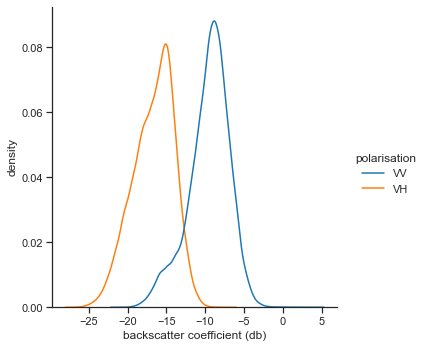

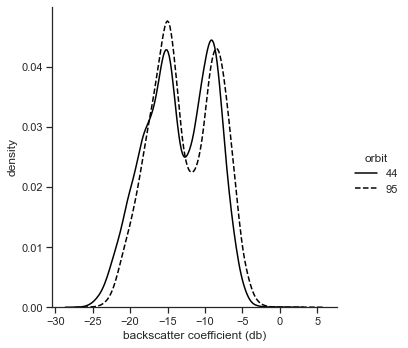

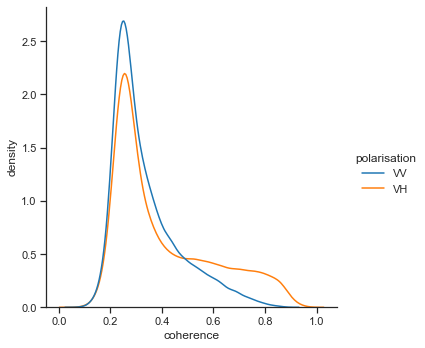

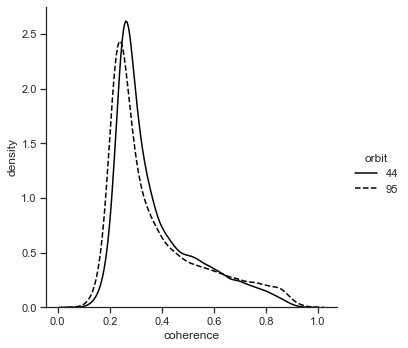

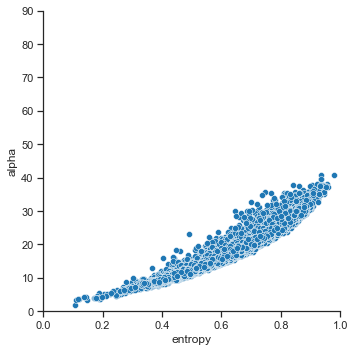

In [37]:
# basic exploratory data analyses
print("Frequency distributions for features over all fields & points in time")
sns.set_style("ticks")
sns.despine()

# frequency distributions for backscatter
f1 = sns.displot(
    data = (field_agg_stats[field_agg_stats["feature"] == "gamma0"]
            .assign(value=lambda df: 10*np.log10(df["value"]))), 
    x = "value",
    hue = "polarisation",
    kind = "kde"
    )
f1.set_axis_labels("backscatter coefficient (db)", "density")
f1.savefig(os.path.join(fig_path, "freq_dist_backscatter_pol.png"), dpi=300);

f2 = sns.displot(
    data = (field_agg_stats[field_agg_stats["feature"] == "gamma0"]
            .assign(value=lambda df: 10*np.log10(df["value"]))), 
    x = "value",
    hue = "orbit",
    palette = ['#000000', '#000000'],
    kind = "kde"
    )

lss = ['--', '-']
for ax in f2.axes.flat:
    for line, ls in zip(ax.lines, lss):
        line.set_linestyle(ls)
        
handles = f2._legend.legendHandles[::-1]
for handle, ls in zip(handles, lss):
    handle.set_ls(ls)

f2.set_axis_labels("backscatter coefficient (db)", "density")
f2.savefig(os.path.join(fig_path, "freq_dist_backscatter_orbit.png"), dpi=300);

# frequency distributions for coherence
g1 = sns.displot(
    data = field_agg_stats[field_agg_stats["feature"] == "coh"], 
    x = "value",
    hue = "polarisation",
    kind = "kde"
    )
g1.set_axis_labels("coherence", "density")
g1.savefig(os.path.join(fig_path, "freq_dist_coherence_pol.png"), dpi=300);

g2 = sns.displot(
    data = field_agg_stats[field_agg_stats["feature"] == "coh"],
    x = "value",
    hue = "orbit",
    palette = ['#000000', '#000000'],
    kind = "kde"
    )

lss = ['--', '-']
for ax in g2.axes.flat:
    for line, ls in zip(ax.lines, lss):
        line.set_linestyle(ls)
        
handles = g2._legend.legendHandles[::-1]
for handle, ls in zip(handles, lss):
    handle.set_ls(ls)

g2.set_axis_labels("coherence", "density")
g2.savefig(os.path.join(fig_path, "freq_dist_coherence_orbit.png"), dpi=300); 


# H-a-plot for dual pol data
# for implementation for quad-pol see: https://chowdera.com/2022/04/202204062024281206.html

# get entropy and alpha for current data
h_a_df = (
    field_agg_stats[field_agg_stats["feature"].isin(["entropy", "alpha"])]
    .loc[:,["field_fid", "time", "feature", "value"]]
    .pivot_table(index=["field_fid", "time"], columns="feature", values="value")
)

# plot H-a-plane 
f3 = sns.relplot(
    data = h_a_df, 
    x = "entropy",
    y = "alpha"
    )

f3.set(xlim=(0,1))
f3.set(ylim=(0,90))
f3.savefig(os.path.join(fig_path, "h_a_plane.png"), dpi=300);

## 04 Timeseries analyses

In [ ]:
# t.b.d: Add some exploratory plots and describe them!!!
# eg show that there is no difference between orbits in overall frequency distributions

# temporal plots for each crop_type/field_use
# averaged over all fields with uncertainty measure (sd)
# for both features & polarisations & orbits

# detailed plot for one crop_type with all fields as lines
# field size dependent plots

# feature engineering related plots
# e.g. time of highest correlation/correlation drop

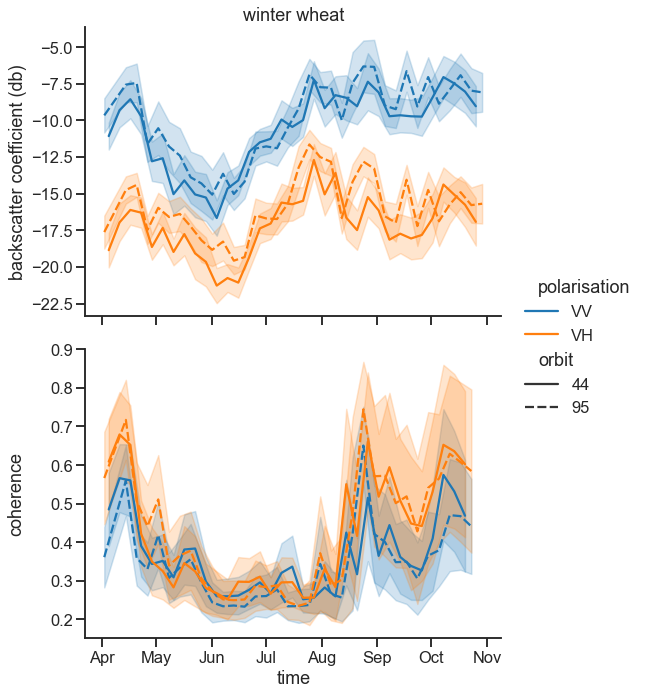

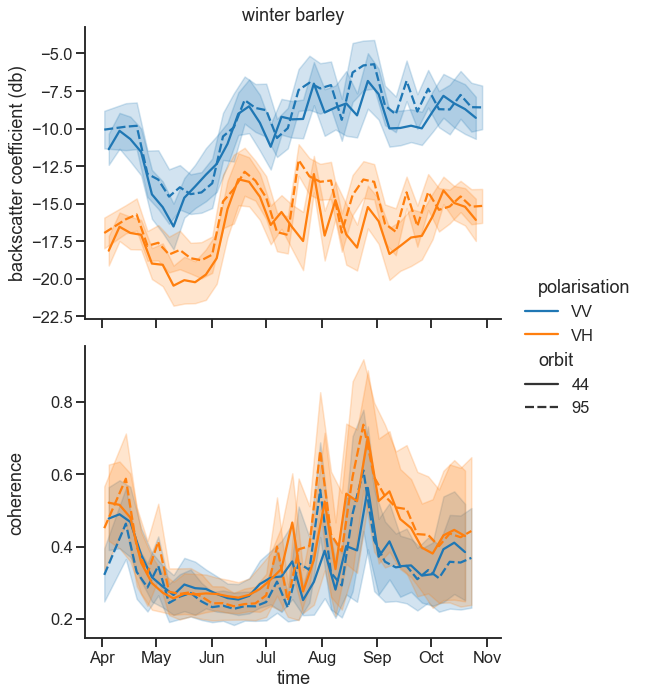

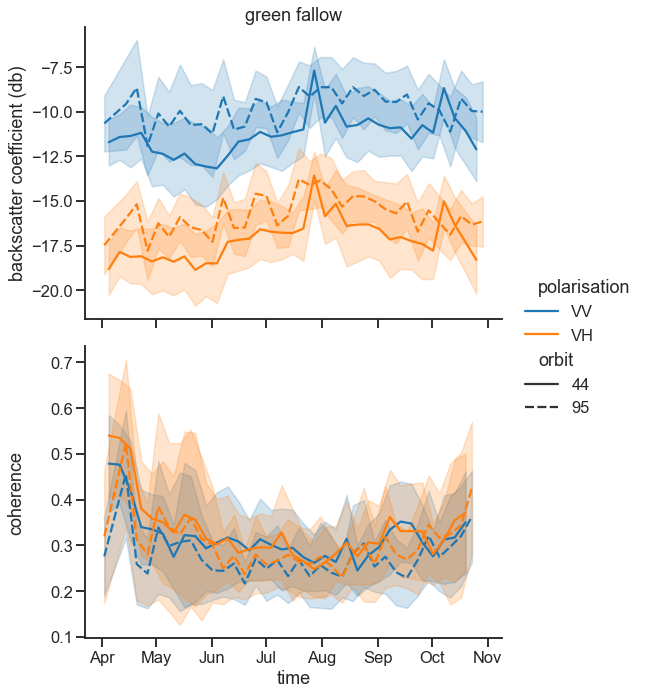

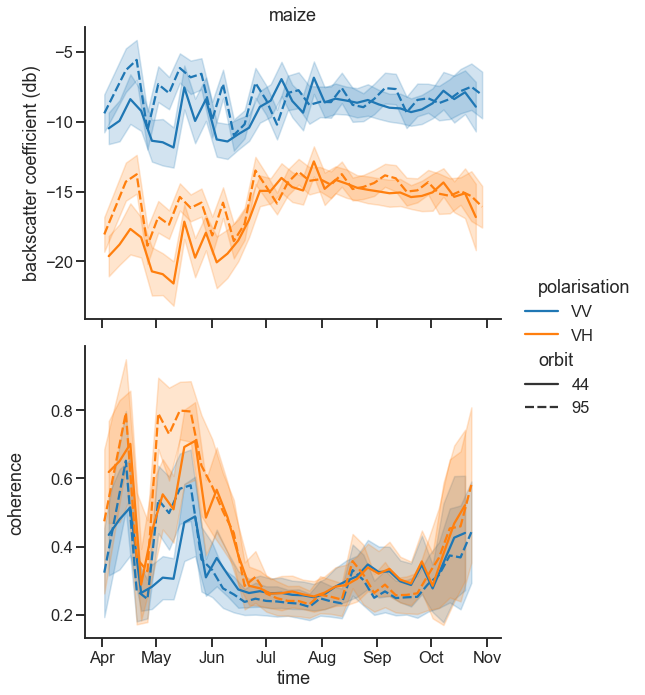

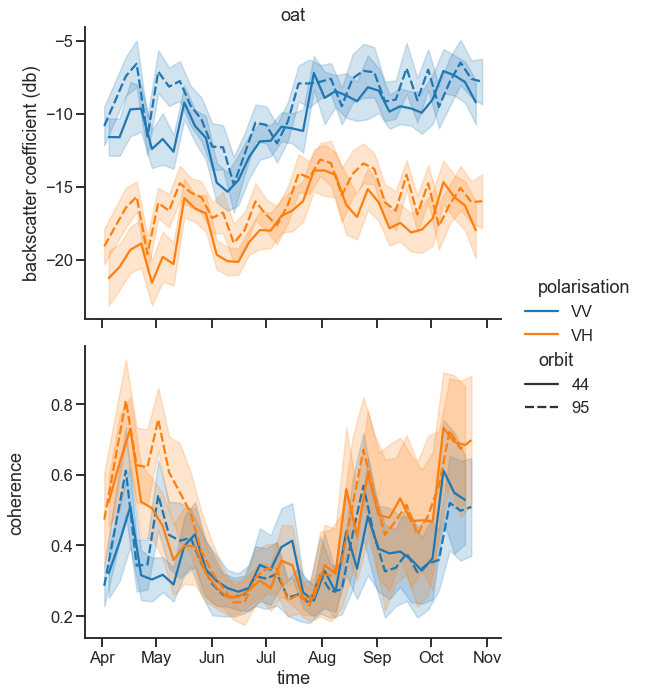

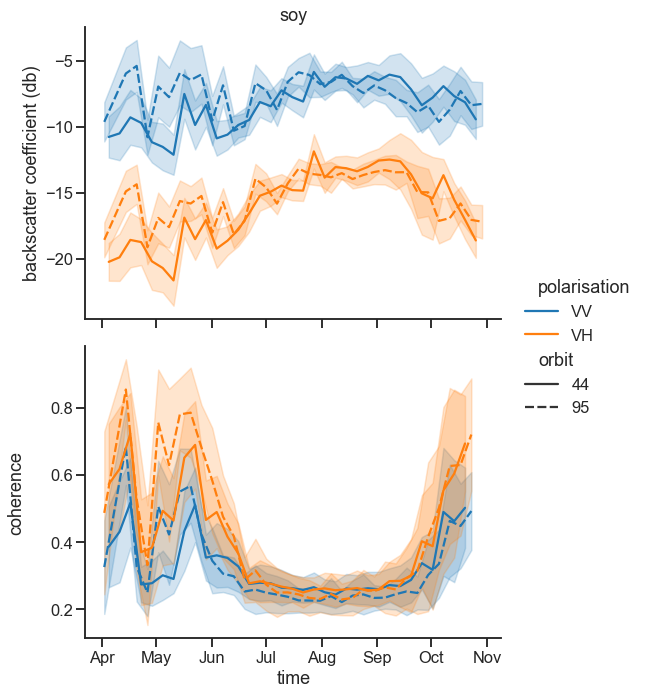

In [18]:
# uniform/standardised plotting aesthetics
# colors for crops
# styles for polarisations
# size for orbits

def log_transform(x):
    vals_transformed = map(
        lambda feat, val: 10*np.log10(val) if feat == "gamma0" else val, 
        x["feature"], x["value"])
    return list(vals_transformed)

def timeseries_plots_crops(crop):
    # filter df    
    plot_df = (field_agg_stats[field_agg_stats["field_use"] == crop]
            .assign(value=lambda df: log_transform(df)))
    # create basic plot
    sns.set_context("talk")
    h = sns.relplot(
        data = plot_df,
        x = "time",
        y = "value",
        ci = "sd",
        hue = "polarisation",
        row = "feature",
        kind = "line",
        style = "orbit",
        aspect = 1.5,
        facet_kws=dict(sharey=False)
        )
    # format datetimes on x axis
    x_dates = pd.Series([x.get_text() for x in h.axes[1,0].get_xticklabels()])
    x_dates = pd.to_datetime(x_dates).dt.strftime('%b')
    h.set_xticklabels(labels=x_dates, rotation=0)
    # format labels & layout
    h.axes[0,0].set_ylabel('backscatter coefficient (db)');
    h.axes[1,0].set_ylabel('coherence\n');
    h.axes[0,0].set_title(crop);
    h.axes[1,0].set_title("");
    h.tight_layout(h_pad = 1);
    # save figure
    h.savefig(os.path.join(fig_path, f"timeseries_{crop.replace(' ', '_')}.png"), dpi=300)

for crop_type in field_agg_stats["field_use"].unique().tolist():
    timeseries_plots_crops(crop_type)

# estimator=None
# units = "field_fid" split variable

Approach
* moving average per field, feature & orbit
* mean between two orbit-specific time series  

In [25]:
# transform df to construct features
# basis can smoothened timeseries (window of 18 days)
# feature 1: mimium coherence (point in time)
# feature 2: sth wrt to curvature trend in backscatter

# averaging over 60 days (window of 10, orbit-specific)
ts_sm = (field_agg_stats
 .assign(value=lambda df: log_transform(df))
 .filter(items=["field_fid", "field_use", "feature", "polarisation", "orbit", "value"], axis=1)
 .groupby(["field_fid", "field_use", "feature", "orbit", "polarisation"])
 .transform(lambda x: x.rolling(window=10, center=True).mean()))

field_agg_stats_II = field_agg_stats.join(ts_sm, rsuffix="_sm", how="left")

# averaging over both orbits
# note transform instead of agg is used as orbit revisits at different times 
ts_sm_avg = (field_agg_stats_II
 .filter(items=["field_fid", "field_use", "feature", "polarisation", "value_sm"], axis=1)
 .groupby(["field_fid", "field_use", "feature", "polarisation"])
 .transform(lambda x: x.rolling(window=2, center=True).mean())
 )

field_agg_stats_II = field_agg_stats_II.join(ts_sm_avg, rsuffix="_avg", how="left")

# calculate slope based on smoothed values
ts_slope = (field_agg_stats_II
 .filter(items=["field_fid", "field_use", "feature", "polarisation", "value_sm_avg"], axis=1)
 .groupby(["field_fid", "field_use", "feature", "polarisation"])
 .transform(lambda x: pd.Series(np.gradient(x)).rolling(window=3, center=True).mean())
 )

field_agg_stats_II = field_agg_stats_II.join(ts_slope, rsuffix="_slope", how="left")

# calculate curvature based on smoothed values
ts_curvature = (field_agg_stats_II
 .filter(items=["field_fid", "field_use", "feature", "polarisation", "value_sm_avg_slope"], axis=1)
 .groupby(["field_fid", "field_use", "feature", "polarisation"])
 .transform(lambda x: pd.Series(np.gradient(x)).rolling(window=3, center=True).mean())
 .rename(columns={"value_sm_avg_slope" : "value_sm_avg"})
 )

field_agg_stats_II = field_agg_stats_II.join(ts_curvature, rsuffix="_curv", how="left")

In [26]:
# transform feature engineered df into tidy form
id_cols = np.array(field_agg_stats_II.columns)[~np.array(["value" in x for x in field_agg_stats_II.columns])]
value_cols = np.array(field_agg_stats_II.columns)[np.array(["value" in x for x in field_agg_stats_II.columns])]
field_agg_stats_II = pd.melt(field_agg_stats_II, id_vars=id_cols, value_vars=value_cols)
field_agg_stats_II = field_agg_stats_II[~field_agg_stats_II["variable"].isin(["value", "value_sm"])]
field_agg_stats_II

C:\Users\felix\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py:3457: FutureWarning: This dataframe has a column name that matches the 'value_name' column name of the resulting Dataframe. In the future this will raise an error, please set the 'value_name' parameter of DataFrame.melt to a unique name.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [1163]:
# new plotting of smoothed curves
def timeseries_plots_crops(crop):
    # filter df
    _filter = ((field_agg_stats_II["variable"] == "value_sm_avg") & 
               (field_agg_stats_II["field_use"] == crop))
    plot_df = field_agg_stats_II.loc[_filter]
    # create basic plot
    sns.set_context("talk")
    h = sns.relplot(
        data = plot_df,
        x = "time",
        y = "value",
        ci = "sd",
        hue = "polarisation",
        row = "feature",
        kind = "line",
        aspect = 1.5,
        facet_kws=dict(sharey=False)
        )
    # format datetimes on x axis
    x_dates = pd.Series([x.get_text() for x in h.axes[1,0].get_xticklabels()])
    x_dates = pd.to_datetime(x_dates).dt.strftime('%b')
    h.set_xticklabels(labels=x_dates, rotation=0)
    # format labels & layout
    h.axes[0,0].set_ylabel('backscatter coefficient (db)');
    h.axes[1,0].set_ylabel('coherence\n');
    h.axes[0,0].set_title(crop);
    h.axes[1,0].set_title("");
    h.tight_layout(h_pad = 1);
    # save figure
    h.savefig(os.path.join(fig_path, f"ts_smoothed_{crop.replace(' ', '_')}.png"), dpi=300)
    plt.close()

for crop_type in field_agg_stats["field_use"].unique().tolist():
    timeseries_plots_crops(crop_type)

In [1067]:
# _filter = ((field_agg_stats_II["variable"].isin(["value_sm_avg", "value_sm_avg_slope", "value_sm_avg_curv"])) &
#             (field_agg_stats_II["feature"] == "coh") &
#             (field_agg_stats_II["orbit"] == 44) &
#             (field_agg_stats_II["field_use"] == "winter wheat"))
# plot_df = field_agg_stats_II.loc[_filter]
# plot_df.sort_values(["field_fid", "polarisation", "time"]).iloc[30:55,:]

In [1164]:
# new plotting of smoothed curves
def timeseries_plots_crops(crop):
    # filter df
    _filter = ((field_agg_stats_II["variable"].isin(["value_sm_avg_slope", "value_sm_avg_curv"])) &
               (field_agg_stats_II["feature"] == "coh") &
               (field_agg_stats_II["orbit"] == 44) &
               (field_agg_stats_II["field_use"] == crop))
    plot_df = field_agg_stats_II.loc[_filter]
    # create basic plot
    sns.set_context("talk")
    h = sns.relplot(
        data = plot_df,
        x = "time",
        y = "value",
        ci = "sd",
        hue = "polarisation",
        row = "variable",
        kind = "line",
        aspect = 1.5,
        facet_kws=dict(sharey=False)
        )
    # format datetimes on x axis
    x_dates = pd.Series([x.get_text() for x in h.axes[1,0].get_xticklabels()])
    x_dates = pd.to_datetime(x_dates).dt.strftime('%b')
    h.set_xticklabels(labels=x_dates, rotation=0)
    # format labels & layout
    h.axes[0,0].set_ylabel('slope coherence');
    h.axes[1,0].set_ylabel('curvature coherence');
    h.axes[0,0].set_title(crop);
    h.axes[1,0].set_title("");
    h.tight_layout(h_pad = 1);
    # save figure
    h.savefig(os.path.join(fig_path, f"ts_slope_curvature_{crop.replace(' ', '_')}.png"), dpi=300)
    plt.close()

for crop_type in field_agg_stats["field_use"].unique().tolist():
    timeseries_plots_crops(crop_type)

In [30]:
field_agg_stats_II

,field_fid,field_use,size_ha,size_buffer_ha,satellite,orbit,feature,polarisation,time,variable,value
405168,87354,winter wheat,2.180543,0.998995,S1A,95,gamma0,VV,2021-04-02 05:18:15,value_sm_avg,NaN
405169,87851,winter barley,1.805346,0.192104,S1A,95,gamma0,VV,2021-04-02 05:18:15,value_sm_avg,NaN
405170,87852,winter wheat,1.705784,0.791518,S1A,95,gamma0,VV,2021-04-02 05:18:15,value_sm_avg,NaN
405171,87923,winter barley,1.324868,0.139216,S1A,95,gamma0,VV,2021-04-02 05:18:15,value_sm_avg,NaN
405172,88142,winter wheat,1.951351,0.986836,S1A,95,gamma0,VV,2021-04-02 05:18:15,value_sm_avg,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1012915,2568748,maize,7.701859,5.159736,S1A,95,coh,VH,2021-10-23 05:18:25,value_sm_avg_curv,NaN
1012916,2568778,oat,1.689632,0.808753,S1A,95,coh,VH,2021-10-23 05:18:25,value_sm_avg_curv,NaN
1012917,2568780,winter barley,1.821018,0.818094,S1A,95,coh,VH,2021-10-23 05:18:25,value_sm_avg_curv,NaN
1012918,2595302,soy,2.795305,1.411348,S1A,95,coh,VH,2021-10-23 05:18:25,value_sm_avg_curv,NaN


In [185]:
# calculate ...
# for each function (orig, 1st derivate, 2nd derivate) - 3x
# for each polarisation - 2x
# for each radar feature - 2x 
# min, min_t, max, max_t, mean, sd, slope of regression line - 6x
# note that slope of regression line is equivalent to mean of derivate
# result: 72 features for classification

def calc_timeseries_features(df):
    df = df.dropna()
    stats = {}
    stats['min'] = np.min(df["value"])
    stats['min_t'] = df[df["value"] == np.min(df["value"])]["time"].tolist()[0]
    stats['max'] = np.max(df["value"])
    stats['max_t'] = df[df["value"] == np.max(df["value"])]["time"].tolist()[0]
    stats['mean'] = np.mean(df["value"])
    stats["sd"] = np.std(df["value"])
    X = np.array(df["time"]).reshape(-1,1)
    y = np.array(df["value"]).reshape(-1,1)
    mod = LinearRegression().fit(X, y)
    stats["lin_reg_slope"] = float(mod.coef_)
    return pd.Series(stats)

_field_agg_stats = (field_agg_stats_II
 .groupby(["field_fid", "field_use", "feature", "polarisation", "variable"])
 .apply(calc_timeseries_features)
 .reset_index())

_field_agg_stats

,field_fid,field_use,feature,polarisation,variable,min,min_t,max,max_t,mean,sd,lin_reg_slope
0,87354,winter wheat,coh,VH,value_sm_avg,0.246648,2021-07-03 16:59:17,0.518955,2021-09-25 16:59:21,0.317843,0.078620,1.734556e-17
1,87354,winter wheat,coh,VH,value_sm_avg_curv,-0.003962,2021-09-17 05:18:24,0.006285,2021-08-30 05:17:42,0.000654,0.002022,-5.745330e-20
2,87354,winter wheat,coh,VH,value_sm_avg_slope,-0.012253,2021-05-16 16:59:14,0.025195,2021-09-11 05:17:42,0.004655,0.008760,2.126911e-18
3,87354,winter wheat,coh,VV,value_sm_avg,0.223464,2021-06-15 16:58:32,0.426078,2021-09-25 16:59:21,0.282418,0.056954,1.290339e-17
4,87354,winter wheat,coh,VV,value_sm_avg_curv,-0.002825,2021-09-17 05:18:24,0.004674,2021-09-01 16:59:20,0.000524,0.001578,-3.664971e-20
...,...,...,...,...,...,...,...,...,...,...,...,...
8803,2601584,soy,gamma0,VH,value_sm_avg_curv,-0.048342,2021-09-07 16:58:37,0.053438,2021-05-26 05:17:36,-0.003002,0.022745,-3.270108e-18
8804,2601584,soy,gamma0,VH,value_sm_avg_slope,-0.180244,2021-09-29 05:18:25,0.204145,2021-07-15 16:59:18,0.072361,0.089918,-1.271861e-17
8805,2601584,soy,gamma0,VV,value_sm_avg,-8.571340,2021-05-26 05:17:36,-6.310373,2021-10-05 05:17:43,-7.675863,0.638070,1.521082e-16
8806,2601584,soy,gamma0,VV,value_sm_avg_curv,-0.039171,2021-07-25 05:17:40,0.067894,2021-05-26 05:17:36,0.005334,0.023420,-1.308678e-19


In [258]:
# uncomment following line to evaluate influence of coherence features
# _field_agg_stats = _field_agg_stats[_field_agg_stats["feature"] == "gamma0"]

# uncomment following line to evaluate influence of timeseries feature engineering
# df = (field_agg_stats
#     .drop(columns=["size_ha", "size_buffer_ha", "satellite"])
#     .pivot(index=["field_fid", "field_use"], 
#            columns=["polarisation", "feature", "orbit", "time"], 
#            values=["value"]))

# col_part_I = [' '.join(col[:-2]).strip() for col in df.columns.values]
# col_part_II = [str(x[-2]) for x in df.columns.values]
# col_part_III = [str(x[-1].day_of_year) for x in df.columns.values]

# df.columns = [' '.join(col).strip() for col in zip(col_part_I, col_part_II, col_part_III)]
# df.reset_index(inplace=True)

# reshape to obtain necessary wide-form format
df2 = _field_agg_stats.pivot(
    index=["field_fid", "field_use"], 
    columns=["polarisation", "feature", "variable"], 
    values=["min", "min_t", "max", "max_t", "mean", "sd", "lin_reg_slope"])

df2.columns = [' '.join(col).strip() for col in df2.columns.values]
df2.reset_index(inplace=True)

# convert timestamps into day of year
for col in df2.select_dtypes("datetime64"):
    df2[col] = [x.day_of_year for x in df2[col]]

#df = df.merge(df2.drop(columns=["field_use"]), on="field_fid")
df = df2
df

,field_fid,field_use,value VV gamma0 95 92,value VV gamma0 44 94,value VV gamma0 44 100,value VV gamma0 95 104,value VV gamma0 44 106,value VV gamma0 95 110,value VV gamma0 44 112,value VV gamma0 95 116,...,value VH coh 44 268,value VH coh 95 272,value VH coh 44 274,value VH coh 95 278,value VH coh 44 280,value VH coh 95 284,value VH coh 44 286,value VH coh 95 290,value VH coh 44 292,value VH coh 95 296
0,87354,winter wheat,0.097831,0.083523,0.131933,0.121865,0.132982,0.118177,0.089764,0.048397,...,0.698118,0.745346,0.850748,0.748274,0.873634,0.778495,0.825295,0.745462,0.643839,0.567958
1,87851,winter barley,0.147138,0.101895,0.159331,0.186572,0.133943,0.106939,0.095379,0.072942,...,0.295013,0.589302,0.291054,0.246842,0.317260,0.273714,0.775464,0.821204,0.750653,0.712784
2,87852,winter wheat,0.110407,0.077485,0.140862,0.224675,0.214328,0.205997,0.126338,0.071606,...,0.475593,0.741593,0.715584,0.708377,0.664869,0.742508,0.713893,0.812483,0.603116,0.674966
3,87923,winter barley,0.112739,0.102530,0.102583,0.073584,0.082099,0.069296,0.099135,0.034052,...,0.309798,0.431391,0.311576,0.274261,0.312419,0.210333,0.338360,0.351019,0.278542,0.330292
4,88142,winter wheat,0.127533,0.101823,0.156219,0.210471,0.181124,0.200671,0.111545,0.066690,...,0.587242,0.810180,0.760694,0.803650,0.786555,0.805336,0.769423,0.820423,0.662068,0.647720
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
729,2568748,maize,0.125699,0.073808,0.108677,0.232377,0.157981,0.296859,0.133818,0.084155,...,0.342589,0.297803,0.255635,0.354488,0.284962,0.444590,0.480638,0.475518,0.636947,0.591342
730,2568778,oat,0.098083,0.060134,0.068620,0.262838,0.149888,0.351365,0.137037,0.109315,...,0.548453,0.622886,0.592906,0.658979,0.779161,0.779347,0.794983,0.748370,0.763781,0.232428
731,2568780,winter barley,0.111774,0.062875,0.123248,0.100723,0.106122,0.104860,0.063410,0.060686,...,0.494333,0.534647,0.485435,0.510389,0.483024,0.543312,0.499230,0.551616,0.403959,0.492037
732,2595302,soy,0.176408,0.092975,0.105682,0.454856,0.158422,0.555743,0.111618,0.112248,...,0.314072,0.244817,0.238617,0.628982,0.770664,0.789934,0.721159,0.827681,0.743883,0.805519


## 05 Crop classification 

In [ ]:

# investigate timings of significant values per field
# inlcude them in final rf to see if something improves -> if not discard idea

# first try random forest
X = df[df.columns[2:]]
y = df["field_use"]

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn import tree
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV

# # single run
# seed = 42
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)
# mod_rf = RandomForestClassifier(random_state = seed, class_weight='balanced').fit(X_train, y_train)
# mod_pred = mod_rf.predict(X_test)
# print(f"Accuracy: {metrics.accuracy_score(y_test, mod_pred).round(2)}")
# print(f"F1-Score: {metrics.f1_score(y_test, mod_pred, average='macro').round(2)}")
# print(f"Precision: {metrics.precision_score(y_test, mod_pred, average='macro').round(2)}")
# print(f"Recall: {metrics.recall_score(y_test, mod_pred, average='macro').round(2)}")

# multiple runs
m_metrics = []
for seed in np.random.randint(low=0, high=10000, size=10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)
    mod_rf = RandomForestClassifier(random_state = seed).fit(X_train, y_train)
    mod_pred = mod_rf.predict(X_test)
    s_metric = {}
    s_metric["accuracy"] = metrics.accuracy_score(y_test, mod_pred)
    s_metric["f1score"] = metrics.f1_score(y_test, mod_pred, average='macro')
    s_metric["recall"] = metrics.recall_score(y_test, mod_pred, average='macro')
    m_metrics.append(s_metric)

print("Evaluation metrics averaged over multiple rf runs:")
print(pd.DataFrame(m_metrics).mean().round(3))

# plot confusion matrix
cf_matrix = metrics.confusion_matrix(y_test, mod_pred)
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')
ax.set_xlabel('\npredicted crop type')
ax.set_ylabel('actual crop type\n')
ax.xaxis.set_ticklabels(mod_rf.classes_,rotation=45,ha='right', rotation_mode='anchor')
ax.tick_params(left=False, bottom=False)
ax.yaxis.set_ticklabels(mod_rf.classes_,rotation=0);

# try mlp
# note: no significant improvements compared to rf
default_mlp_params = {"max_iter":2000, "verbose":False, "hidden_layer_sizes": (20, 20, 20, 20, 20,10), "early_stopping":True, "tol":1e-6}
m_metrics = []

for seed in np.random.randint(low=0, high=10000, size=20):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)
    mod_mlp = make_pipeline(StandardScaler(), MLPClassifier(random_state = seed, **default_mlp_params))
    mod_mlp = mod_mlp.fit(X_train, y_train)
    mod_pred = mod_mlp.predict(X_test)
    s_metric = {}
    s_metric["accuracy"] = metrics.accuracy_score(y_test, mod_pred)
    s_metric["f1score"] = metrics.f1_score(y_test, mod_pred, average='macro')
    s_metric["recall"] = metrics.recall_score(y_test, mod_pred, average='macro')
    m_metrics.append(s_metric)

print("Evaluation metrics averaged over multiple rf runs:")
print(pd.DataFrame(m_metrics).sort_values("accuracy", ascending=False))

In [ ]:
# df = df_ad.merge(df_cvm.drop(columns="field_use"), on="field_fid")

# reformat as prep for classification
df = field_agg_stats.pivot(
    index=["field_fid", "field_use"], 
    columns=["polarisation", "time"], 
    values=["value"])

col_part_I = [' '.join(col[:-1]).strip() for col in df.columns.values]
col_part_III = [str(x[-1].day_of_year) for x in df.columns.values]

df.columns = [' '.join(col).strip() for col in zip(col_part_I, col_part_III)]
df.reset_index(inplace=True)

per_field = field_agg_stats[field_agg_stats["value"] < 0.05].groupby("field_fid")["value"].count()
df = df.set_index("field_fid").join(per_field)
df = df.reset_index().fillna(0)

df


selected_crop = "winter wheat"
df.value_counts("field_use")[df.value_counts("field_use").index == selected_crop] 
field_agg_stats[(field_agg_stats["field_use"] == selected_crop) & (field_agg_stats["value"] < 0.001)].hist("time", bins=100)


(field_agg_stats[(field_agg_stats["field_use"] == "winter wheat") &
                (field_agg_stats["time"] > "2021-04-30") &
                (field_agg_stats["time"] < "2021-06-15")
                #& (field_agg_stats["field_fid"] == 2106253)
                ].
    sort_values(["time"]).
    iloc[:50,:]
)

# time minimal influence
(field_agg_stats
    .sort_values("value")
    .iloc[:300,:]
    .hist("time")
    )

(field_agg_stats
    .sort_values("value")
    .iloc[:300,:]
    .value_counts("field_use")
    )

C:\Users\felix\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evaluation metrics averaged over multiple rf runs (only not engineered df):
accuracy     0.958
f1score      0.910
precision    0.970
recall       0.874
dtype: float64


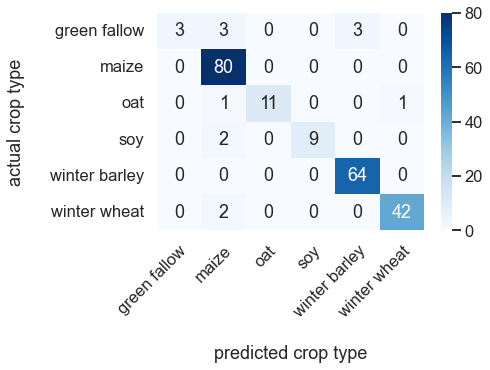

In [259]:
# first try random forest
X = df[df.columns[2:]]
y = df["field_use"]

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn import tree
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import RandomizedSearchCV

# # single run
# seed = 42
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)
# mod_rf = RandomForestClassifier(random_state = seed, class_weight='balanced').fit(X_train, y_train)
# mod_pred = mod_rf.predict(X_test)
# print(f"Accuracy: {metrics.accuracy_score(y_test, mod_pred).round(2)}")
# print(f"F1-Score: {metrics.f1_score(y_test, mod_pred, average='macro').round(2)}")
# print(f"Precision: {metrics.precision_score(y_test, mod_pred, average='macro').round(2)}")
# print(f"Recall: {metrics.recall_score(y_test, mod_pred, average='macro').round(2)}")

# multiple runs
m_metrics = []
for seed in np.random.randint(low=0, high=10000, size=1000):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)
    mod_rf = RandomForestClassifier(random_state = seed, class_weight='balanced').fit(X_train, y_train)
    mod_pred = mod_rf.predict(X_test)
    s_metric = {}
    s_metric["accuracy"] = metrics.accuracy_score(y_test, mod_pred)
    s_metric["f1score"] = metrics.f1_score(y_test, mod_pred, average='macro')
    s_metric["precision"] = metrics.precision_score(y_test, mod_pred, average='macro')
    s_metric["recall"] = metrics.recall_score(y_test, mod_pred, average='macro')
    m_metrics.append(s_metric)

print("Evaluation metrics averaged over multiple rf runs (only not engineered df):")
print(pd.DataFrame(m_metrics).mean().round(3))

# plot confusion matrix
cf_matrix = metrics.confusion_matrix(y_test, mod_pred)
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')
ax.set_xlabel('\npredicted crop type')
ax.set_ylabel('actual crop type\n')
ax.xaxis.set_ticklabels(mod_rf.classes_, rotation=45, ha='right', rotation_mode='anchor')
ax.tick_params(left=False, bottom=False)
ax.yaxis.set_ticklabels(mod_rf.classes_,rotation=0);

First results
* influence of coherence & feature engineered df increases accuracy measures but only slightly (~1%) (checked for 1000 runs)
* non-feature engineered df performs already fine (timeseries engineering adds not much information)

* Only Accuracy calculated over all classes (and thus significantly influenced by class imbalance)
* Balanced Accuracy as provided with sklearn is nothing else than unweighted average of recall as calculated above
* Macro average as metrics calculated for each label weighted equally
* metric calculation procedure as above more honest than choosing the weighted ones

* extensions necessary in at least two regards...
    * user & producer accuracies should be reported
    * resampling methods applied to obtain estimates of uncertainty for accuracy metrics
-> use best practice guides

In [ ]:
# put both in bivariate plot
def bivariate_plots_crops(crop_list, title_suffix):
    # filter df
    _filter = ((field_agg_stats_III["feature"] == "coh") & 
               (field_agg_stats_III["polarisation"] == "VV") &
               (field_agg_stats_III["field_use"].isin(crop_list)))
    plot_df = field_agg_stats_III.loc[_filter]
    # define color palette for fields use / crop type
    col_field_use = {}
    norm = matplotlib.colors.Normalize(vmin=0, vmax=6, clip=True)
    mapper = cm.ScalarMappable(norm=norm, cmap=cm.Spectral)
    col_lst = [mapper.to_rgba(x) for x in range(0,6)]
    for use, col in zip(fields["field_use"].unique(), col_lst):
        col_field_use.update({use: col})
    # create basic plot
    sns.set_context("talk")
    i = sns.displot(data = plot_df, 
                x = "min_value_t", 
                y = "lin_reg_slope", 
                thresh = 0.2, 
                levels = 5, 
                alpha = 0.85, 
                hue = "field_use",
                kind = "kde",
                palette = col_field_use,
                common_norm = False)
    # format labels & layout
    i.axes[0,0].set_xlabel('time of minimum coherence');
    i.axes[0,0].set_ylabel('coherence curvature \nregression coefficient');
    i.axes[0,0].set_ylim([-5e-19, 4.5e-19]);
    i.axes[0,0].set_xlim([datetime.date(2021, 4, 25), datetime.date(2021, 10, 9)]);
    # format datetimes on x axis
    x_dates = pd.Series([x.get_text() for x in i.axes[0,0].get_xticklabels()])
    x_dates = pd.to_datetime(x_dates).dt.strftime('%b')
    i.set_xticklabels(labels=x_dates, rotation=0)
    # save figure
    i.savefig(os.path.join(fig_path, f"bivar_{title_suffix}.png"), dpi=300)
    #plt.close()

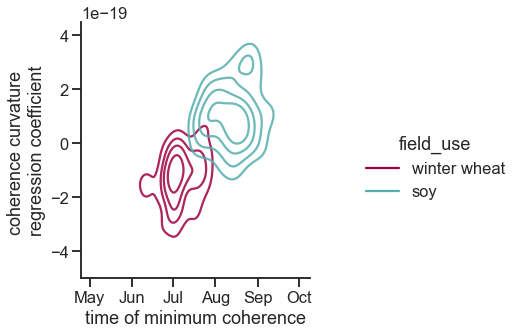

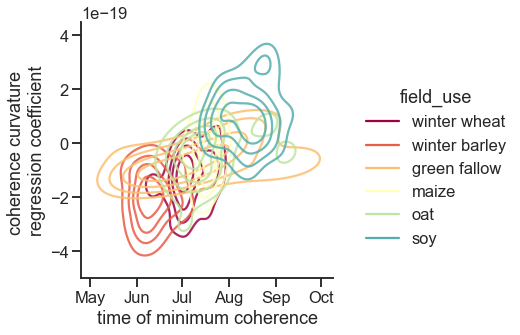

In [1377]:
# adjust colors so that colors are mapped uniquely to crop
# assign color upfront

# put both in bivariate plot
def bivariate_plots_crops(crop_list, title_suffix):
    # filter df
    _filter = ((field_agg_stats_III["feature"] == "coh") & 
               (field_agg_stats_III["polarisation"] == "VV") &
               (field_agg_stats_III["field_use"].isin(crop_list)))
    plot_df = field_agg_stats_III.loc[_filter]
    # create basic plot
    sns.set_context("talk")
    i = sns.displot(data = plot_df, 
                x = "min_value_t", 
                y = "lin_reg_slope", 
                thresh = 0.2, 
                levels = 5, 
                alpha = 0.85, 
                hue = "field_use",
                kind = "kde",
                palette = col_field_use,
                common_norm = False)
    # format labels & layout
    i.axes[0,0].set_xlabel('time of minimum coherence');
    i.axes[0,0].set_ylabel('coherence curvature \nregression coefficient');
    i.axes[0,0].set_ylim([-5e-19, 4.5e-19]);
    i.axes[0,0].set_xlim([datetime.date(2021, 4, 25), datetime.date(2021, 10, 9)]);
    # format datetimes on x axis
    locator = mdates.MonthLocator() 
    fmt = mdates.DateFormatter('%b')
    plt.gca().xaxis.set_major_locator(locator)
    plt.gca().xaxis.set_major_formatter(fmt)
    # save figure
    i.savefig(os.path.join(fig_path, f"bivar_{title_suffix}.png"), dpi=300)
    #plt.close()

bivariate_plots_crops(["winter wheat", "soy"], title_suffix="wheat_soy")
bivariate_plots_crops(fields["field_use"].unique(), title_suffix="all")

In [605]:
#?sns.kdeplot

# plot_df = plot_df.pivot(index=["field_fid", "orbit", "field_use", "time"], columns="polarisation", values="value")
# plot_df

In [ ]:
# classification via following features/approaches
# always think of generalisability

# using smoothened timeseries or even filters seems generally sensible as short-time fluctuations may stem from weather-related factors (-> backscatter)
# phenological develoment characterised by medium term changes

# approach 1: brute force (rf)

# approach 2: bivariate plot with essence of temporal signatures
# sliding window (18 days) with min coherence -> point in time when this is given
# phase of highest temporal variability -> derivate of smoothened coherence timeseries
# curvature trend of smoothened function
# distribution of coherence values -> characterising measures of unimodality/bimodality, spread of values etc

# can be extended by further coherence related features as input for classifier
# just throw a bunch of general function describing parameters at the classifiers
# parameters calculated for two different smoothing windows (12 and 30 days)
# parameters including first & second derivate (curvature)...

# approach 3: knowledge-based manual one
# deviation from optimal crop type defining temporal signature weighted by standard deviation
# fuzzy weighted logics

## Appendix: Backups - etc